In [1]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import pickle

### Parameters

### Loading solved nets

In [82]:
main_case = '20210126_163038'
output_dir = f'../../output/mga/{main_case}/'
base_case = "base"
epsilons = [0.01, 0.02, 0.03, 0.05, 0.1]
min_cases = [f"min_eps{eps}" for eps in epsilons]
max_cases = [f"max_eps{eps}" for eps in epsilons]
cases = [base_case] + min_cases + max_cases
print(cases)
nets = dict.fromkeys(cases)
for case in cases:
    nets[case] = Network()
    nets[case].import_from_csv_folder(f"{output_dir}{case}/")


['base', 'min_eps0.01', 'min_eps0.02', 'min_eps0.03', 'min_eps0.05', 'min_eps0.1', 'max_eps0.01', 'max_eps0.02', 'max_eps0.03', 'max_eps0.05', 'max_eps0.1']


/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/pypsa/io.py:769: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=df.index | columns, fill_value=default)
/home/duboisa1/miniconda3/envs/replan/lib/python3.7/site-packages/pypsa/io.py:771: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  pnl[attr] = pnl[attr].reindex(columns=(pnl[attr].columns | columns))
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, g

## Problem size

### Costs

In [83]:
# Costs of generators
techs = ["ccgt", "load", "pv_utility", "ror",
         "wind_onshore", "wind_offshore"]

capex_opex = pd.DataFrame(index=["capex", "opex"], columns=cases)
costs_all = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases, dtype=float)
for case in cases:
    net = nets[case]
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs_all.loc["Generation", case] = get_generators_cost(net).sum()
    capex_opex.loc["capex", case] = get_links_capex(net).sum()
    capex_opex.loc["opex", case] = get_storage_opex(net).sum()
    costs_all.loc["Transmission", case] = get_links_capex(net).sum()
    costs_all.loc["Storage", case] = get_storage_cost(net).sum()
costs_all.loc["Total"] = costs_all.sum()
print(costs_all[base_case])
print(costs_all[min_cases])
print(costs_all[max_cases])


Generation      4.151354
Transmission    0.122845
Storage         0.013614
Total           4.287812
Name: base, dtype: float64
              min_eps0.01  min_eps0.02  min_eps0.03  min_eps0.05  min_eps0.1
Generation       4.303884     4.335349     4.352959     4.394250    4.510145
Transmission     0.013179     0.000000     0.000000     0.000000    0.000000
Storage          0.013627     0.038014     0.063037     0.107278    0.205110
Total            4.330691     4.373363     4.415996     4.501529    4.715255
              max_eps0.01  max_eps0.02  max_eps0.03  max_eps0.05  max_eps0.1
Generation       4.116725     4.115076     4.115076     4.115076    4.115076
Transmission     0.200365     0.244892     0.287770     0.373527    0.587917
Storage          0.013600     0.013600     0.013600     0.013600    0.013600
Total            4.330690     4.373569     4.416447     4.502203    4.716593


In [84]:
# Cost increase
# Min cases
print((costs_all.loc["Total", min_cases]/costs_all.loc["Total", cases[0]] - 1))
# Maw cases
print((costs_all.loc["Total", max_cases]/costs_all.loc["Total", cases[0]] - 1))

min_eps0.01    0.010000
min_eps0.02    0.019952
min_eps0.03    0.029895
min_eps0.05    0.049843
min_eps0.1     0.099688
Name: Total, dtype: float64
max_eps0.01    0.01
max_eps0.02    0.02
max_eps0.03    0.03
max_eps0.05    0.05
max_eps0.1     0.10
Name: Total, dtype: float64


## Capacities

                     base min_eps0.01 min_eps0.02 min_eps0.03 min_eps0.05  \
ccgt           132.158921  128.509184  125.864249  122.767846  120.527071   
pv_utility      16.596122   17.129960   32.108680   45.220598   51.309701   
wind_onshore   107.245317   53.499148   54.091480   58.370981   70.340447   
wind_offshore  197.275373  221.595583  216.220514  215.047384  211.970954   
AC              19.948819    2.140154    0.000000    0.000000    0.000000   
Li-ion           0.000000    0.000000   14.427775   29.388510   55.995071   

               min_eps0.1  
ccgt           117.987272  
pv_utility      78.965480  
wind_onshore    96.731298  
wind_offshore  203.445334  
AC               0.000000  
Li-ion         115.231483  
                     base max_eps0.01 max_eps0.02 max_eps0.03 max_eps0.05  \
ccgt           132.158921  135.557734  135.912471  135.912471  135.912471   
pv_utility      16.596122   16.404470   16.381220   16.381220   16.381220   
wind_onshore   107.245317  123.69

Text(0.5, 1.0, 'max')

<Figure size 432x288 with 0 Axes>

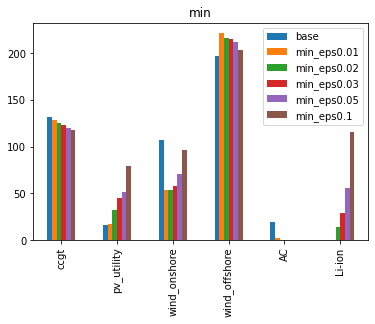

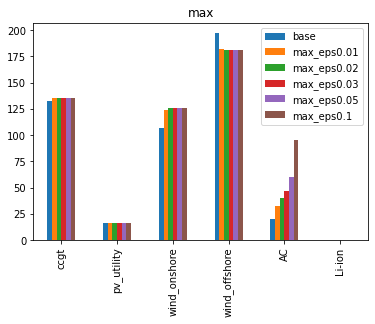

In [85]:
techs = ["ccgt", "pv_utility", "wind_onshore", "wind_offshore", "AC", "Li-ion"]
capacities_df = pd.DataFrame(columns=cases, index=techs)
capacities_init_df = pd.DataFrame(columns=cases, index=techs)
for case in cases:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["new"],
                            get_links_capacity(net)["new [TWkm]"], # + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].values
min_capacities_df = capacities_df[[base_case] + min_cases]
print(min_capacities_df)
max_capacities_df = capacities_df[[base_case] + max_cases]
print(max_capacities_df)
plt.figure()
min_capacities_df.plot(kind="bar")
#plt.legend("")
plt.title("min")
#capacities_init_df.plot(ax=axes[0], kind="bar", color='k', alpha=0.5)
max_capacities_df.plot(kind="bar")
#plt.legend("")
plt.title("max")
#plt.xticks(rotation="45")
# plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

In [86]:
ccgt_gens = net.generators[net.generators.type == "ccgt"]
print((net.generators_t.p[ccgt_gens.index]/ccgt_gens.p_nom_opt).mean())
print(net.generators_t.p[ccgt_gens.index].sum().sum())

BE Gen ccgt    0.201193
DE Gen ccgt    0.285912
FR Gen ccgt    0.175286
LU Gen ccgt    0.046967
NL Gen ccgt    0.094236
dtype: float64
17385.70641162656


## Neumann's plot

ccgt
pv_utility
wind_onshore
wind_offshore
AC
Li-ion


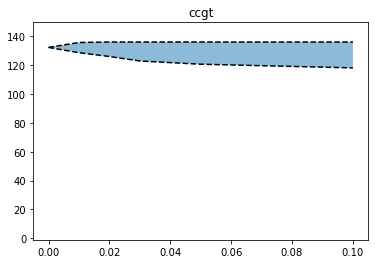

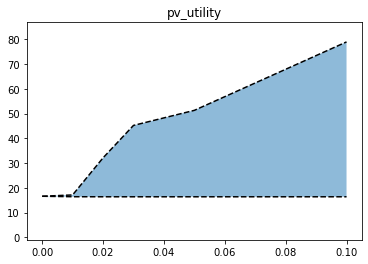

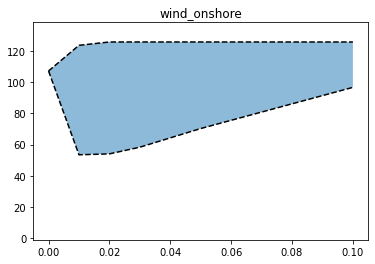

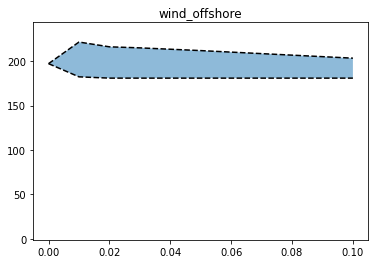

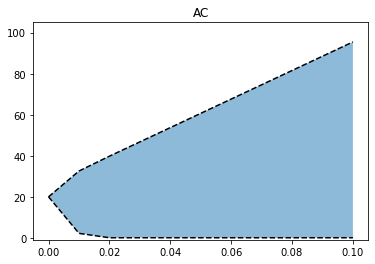

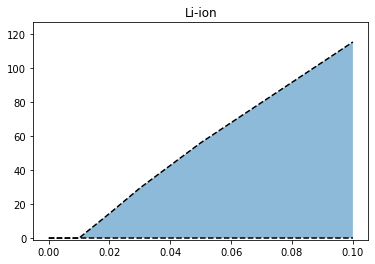

In [87]:
techs = ["ccgt", "pv_utility", "wind_onshore", "wind_offshore", "AC", "Li-ion"]
x = [0] + epsilons
for tech in techs:
    print(tech)
    plt.figure()
    mins = min_capacities_df.loc[tech].values.tolist()
    maxs = max_capacities_df.loc[tech].values.tolist()
    y1 = [min(mi, ma) for mi, ma in zip(mins, maxs)]
    y2 = [max(mi, ma) for mi, ma in zip(mins, maxs)]
    plt.plot(x,y1,'k--')
    plt.plot(x,y2,'k--')
    plt.fill_between(x, y1, y2, alpha=0.5)
    plt.title(tech)
    plt.ylim([-1, max(max(y1), max(y2))*1.1])